# LLM Benchmark & Visualization
This notebook demonstrates how to use the `llama-benchy` library to benchmark an LLM and visualize the results.
To run it, you need to install the dependencies: `uv pip install jupyterlab`, then run `jupyter lab`

In [1]:
!uv pip install matplotlib seaborn pandas ipywidgets

Using Python 3.12.7 environment at: /Users/eugr/Documents/src-personal/llm-bench/.venv
Resolved 33 packages in 167ms                                        
Installed 12 packages in 74ms.0.15                          
 + contourpy==1.3.3
 + cycler==0.12.1
 + fonttools==4.61.1
 + ipywidgets==8.1.8
 + jupyterlab-widgets==3.0.16
 + kiwisolver==1.4.9
 + matplotlib==3.10.8
 + pandas==3.0.0
 + pillow==12.1.0
 + pyparsing==3.3.2
 + seaborn==0.13.2
 + widgetsnbextension==4.0.15


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import asyncio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure src is in the python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from llama_benchy.config import BenchmarkConfig
from llama_benchy.client import LLMClient
from llama_benchy.corpus import TokenizedCorpus
from llama_benchy.prompts import PromptGenerator
from llama_benchy.runner import BenchmarkRunner

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Configuration

Configure the benchmark parameters below. Set your API key and Base URL.
If you are running a local server (e.g., vllm, TGI), the base URL usually looks like `http://localhost:8000/v1`.

In [3]:
# --- USER CONFIGURATION ---
BASE_URL = "http://spark:8888/v1"
API_KEY = "EMPTY"  # Use your actual API key if needed
MODEL_NAME = "openai/gpt-oss-120b" # Change to your model name
SERVED_MODEL_NAME = MODEL_NAME # "gpt-oss-120b"

# Benchmark parameters
CONCURRENCY_LEVELS = [1, 2, 4]
PROMPT_SIZES = [128, 1024, 4096]
GEN_SIZES = [128]
RUNS = 3
# --------------------------

print(f"Configured to benchmark {MODEL_NAME} at {BASE_URL} served as {SERVED_MODEL_NAME}")

Configured to benchmark openai/gpt-oss-120b at http://spark:8888/v1 served as openai/gpt-oss-120b


In [4]:
# Initialize Components

# 1. Config
config = BenchmarkConfig(
    base_url=BASE_URL,
    api_key=API_KEY,
    model=MODEL_NAME,
    served_model_name=SERVED_MODEL_NAME,
    tokenizer=None, # Will auto-detect from model name or fallback
    pp_counts=PROMPT_SIZES,
    tg_counts=GEN_SIZES,
    depths=[0],
    num_runs=RUNS,
    no_cache=False,
    latency_mode="api",
    no_warmup=False,
    adapt_prompt=True,
    enable_prefix_caching=False,
    book_url="https://www.gutenberg.org/files/1661/1661-0.txt",
    post_run_cmd=None,
    concurrency_levels=CONCURRENCY_LEVELS,
    save_all_throughput_timeseries=True,
    save_total_throughput_timeseries=True
)

# 2. Corpus (Downloads text for prompt generation)
print("Initializing Corpus...")
corpus = TokenizedCorpus(config.book_url, config.tokenizer, config.model)

# 3. Prompt Generator
prompt_gen = PromptGenerator(corpus)

# 4. Client
client = LLMClient(config.base_url, config.api_key, config.served_model_name)

# 5. Runner
runner = BenchmarkRunner(config, client, prompt_gen)
print(f"Runner initialized. Config: {config}")

Initializing Corpus...
Loading text from cache: /Users/eugr/.cache/llama-benchy/cc6a0b5782734ee3b9069aa3b64cc62c.txt
Runner initialized. Config: base_url='http://spark:8888/v1' api_key='EMPTY' model='openai/gpt-oss-120b' served_model_name='openai/gpt-oss-120b' tokenizer=None pp_counts=[128, 1024, 4096] tg_counts=[128] depths=[0] num_runs=3 no_cache=False latency_mode='api' no_warmup=False adapt_prompt=True enable_prefix_caching=False book_url='https://www.gutenberg.org/files/1661/1661-0.txt' post_run_cmd=None concurrency_levels=[1, 2, 4] save_result=None result_format='md' save_total_throughput_timeseries=True save_all_throughput_timeseries=True


## Run Benchmark

The following cell executes the benchmark suite. This may take a while depending on the number of runs and concurrency levels.

In [5]:
print("Starting Benchmark Suite...")
await runner.run_suite()
print("Benchmark completed.")

Starting Benchmark Suite...
Warming up...
Warmup (User only) complete. Delta: 65 tokens (Server: 86, Local: 21)
Warmup (System+Empty) complete. Delta: 69 tokens (Server: 90, Local: 21)
Measuring latency using mode: api...
Average latency (api): 23.65 ms
Running test: pp=128, tg=128, depth=0, concurrency=1
  Run 1/3 (batch size 1)...
  Run 2/3 (batch size 1)...
  Run 3/3 (batch size 1)...
Running test: pp=128, tg=128, depth=0, concurrency=2
  Run 1/3 (batch size 2)...
  Run 2/3 (batch size 2)...
  Run 3/3 (batch size 2)...
Running test: pp=128, tg=128, depth=0, concurrency=4
  Run 1/3 (batch size 4)...
  Run 2/3 (batch size 4)...
  Run 3/3 (batch size 4)...
Running test: pp=1024, tg=128, depth=0, concurrency=1
  Run 1/3 (batch size 1)...
  Run 2/3 (batch size 1)...
  Run 3/3 (batch size 1)...
Running test: pp=1024, tg=128, depth=0, concurrency=2
  Run 1/3 (batch size 2)...
  Run 2/3 (batch size 2)...
  Run 3/3 (batch size 2)...
Running test: pp=1024, tg=128, depth=0, concurrency=4
  Run

## Analysis & Visualization

Process the collected results into a Pandas DataFrame and generate plots.

In [6]:
# Extract Data
data = []

# Access the raw run data from the results object
for run in runner.results.runs:
    # Check if metrics exist (they might be None if runs failed)
    ts_mean = run.pp_throughput.mean if run.pp_throughput else 0
    tg_mean = run.tg_throughput.mean if run.tg_throughput else 0
    peak_mean = run.peak_throughput.mean if run.peak_throughput else 0
    ttft_mean = run.e2e_ttft.mean if run.e2e_ttft else 0
    
    data.append({
        "Concurrency": run.concurrency,
        "Prompt Size": run.prompt_size,
        "Output Size": run.response_size,
        "Prefill Throughput (t/s)": ts_mean,
        "Decode Throughput (t/s)": tg_mean,
        "Peak Throughput (t/s)": peak_mean,
        "TTFT (ms)": ttft_mean * 1000 # Convert to ms
    })

df = pd.DataFrame(data)
display(df)

,Concurrency,Prompt Size,Output Size,Prefill Throughput (t/s),Decode Throughput (t/s),Peak Throughput (t/s),TTFT (ms)
0,1,128,128,342.954422,60.708922,62.000000,2.714370e+05
1,2,128,128,270.866618,79.259077,82.666667,4.502748e+05
2,4,128,128,484.019470,108.933142,116.666667,5.074323e+05
3,1,1024,128,2918.696068,59.923139,61.000000,4.249991e+05
4,2,1024,128,3209.683965,81.774736,85.333333,7.249653e+05
5,4,1024,128,4252.261204,108.299708,117.666667,9.444492e+05
6,1,4096,128,6015.914163,58.892959,60.000000,7.518303e+05
7,2,4096,128,6576.812577,79.954047,82.666667,1.245448e+06
8,4,4096,128,6558.738444,104.784571,117.666667,2.482462e+06


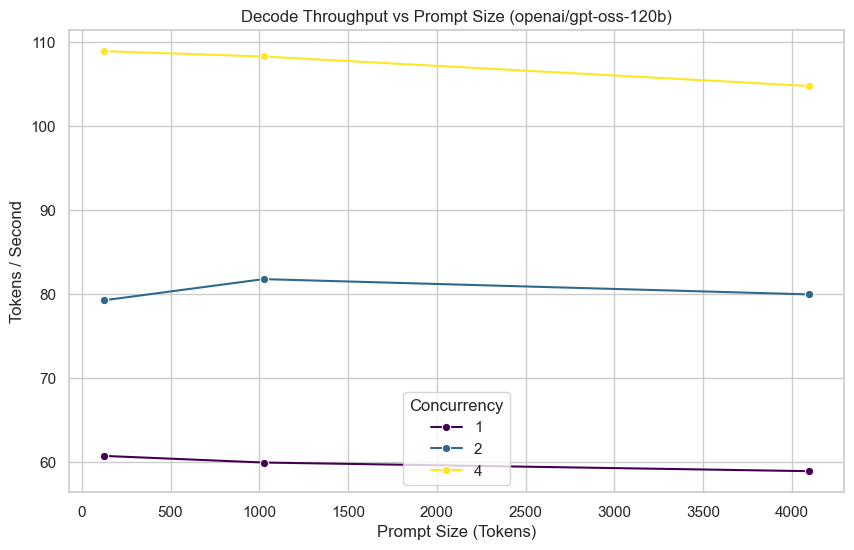

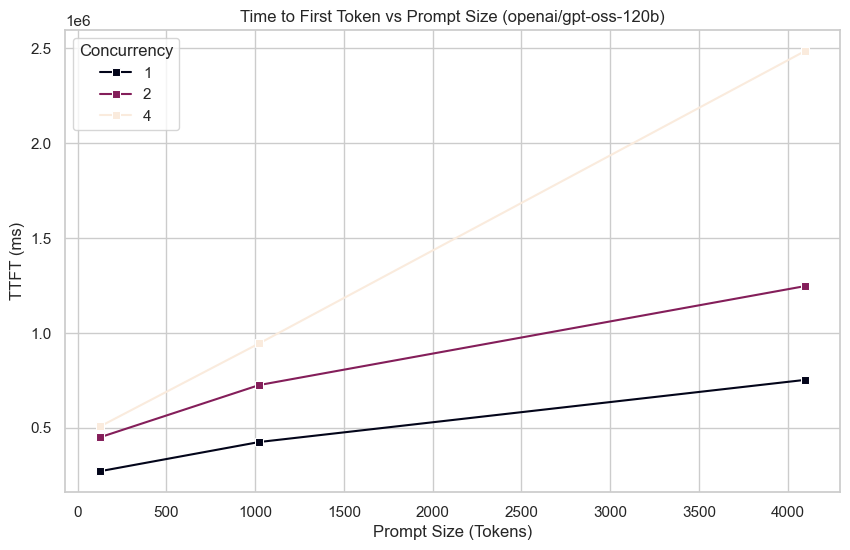

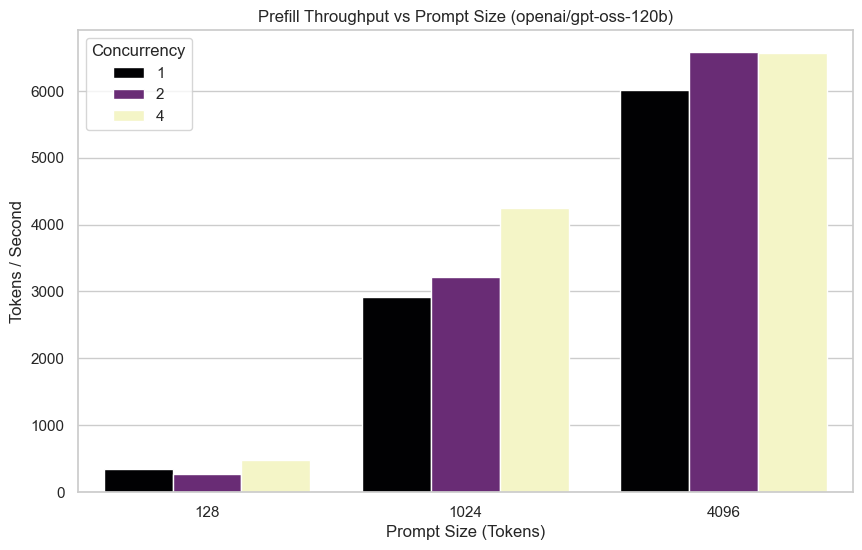

In [7]:
# Visualization

sns.set_theme(style="whitegrid")

# Plot 1: Decode Throughput vs Prompt Size (grouped by Concurrency)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Prompt Size", y="Decode Throughput (t/s)", hue="Concurrency", marker="o", palette="viridis")
plt.title(f"Decode Throughput vs Prompt Size ({MODEL_NAME})")
plt.ylabel("Tokens / Second")
plt.xlabel("Prompt Size (Tokens)")
plt.show()

# Plot 2: TTFT vs Prompt Size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Prompt Size", y="TTFT (ms)", hue="Concurrency", marker="s", palette="rocket")
plt.title(f"Time to First Token vs Prompt Size ({MODEL_NAME})")
plt.ylabel("TTFT (ms)")
plt.xlabel("Prompt Size (Tokens)")
plt.show()

# Plot 3: Prefill Throughput
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Prompt Size", y="Prefill Throughput (t/s)", hue="Concurrency", palette="magma")
plt.title(f"Prefill Throughput vs Prompt Size ({MODEL_NAME})")
plt.ylabel("Tokens / Second")
plt.xlabel("Prompt Size (Tokens)")
plt.show()

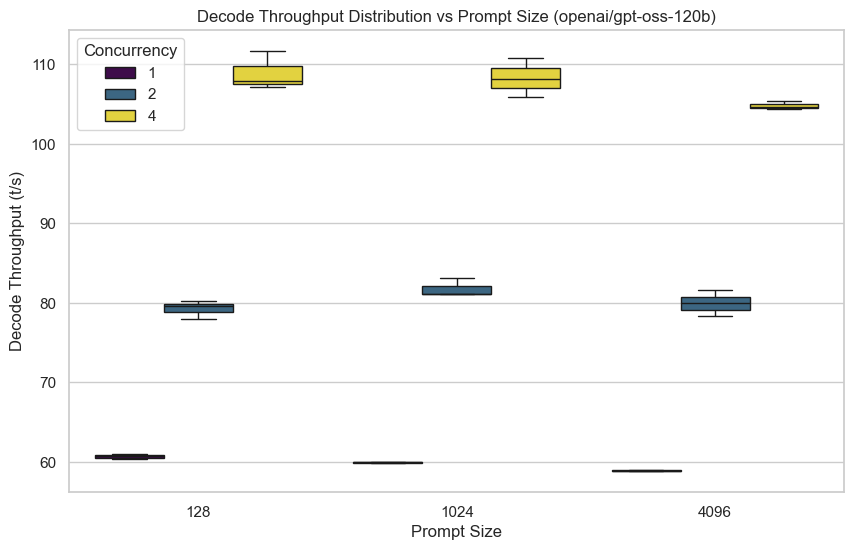

In [8]:
# Whisker plot for Decode Throughput vs Prompt Size
# Collect raw decode throughput samples for each configuration
samples = []
for run in runner.results.runs:
    # Attempt to get individual samples; fallback to mean if not available
    tg_samples = getattr(run.tg_throughput, "values", [run.tg_throughput.mean])
    for val in tg_samples:
        samples.append({
            "Concurrency": run.concurrency,
            "Prompt Size": run.prompt_size,
            "Decode Throughput (t/s)": val,
        })

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_samples = pd.DataFrame(samples)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_samples, x="Prompt Size", y="Decode Throughput (t/s)", hue="Concurrency", palette="viridis")
plt.title(f"Decode Throughput Distribution vs Prompt Size ({MODEL_NAME})")
plt.show()

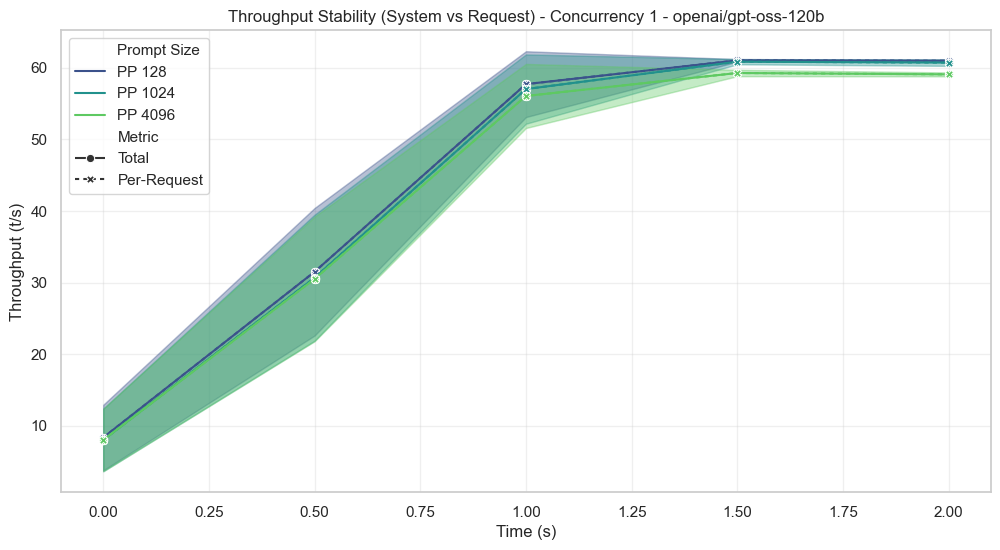

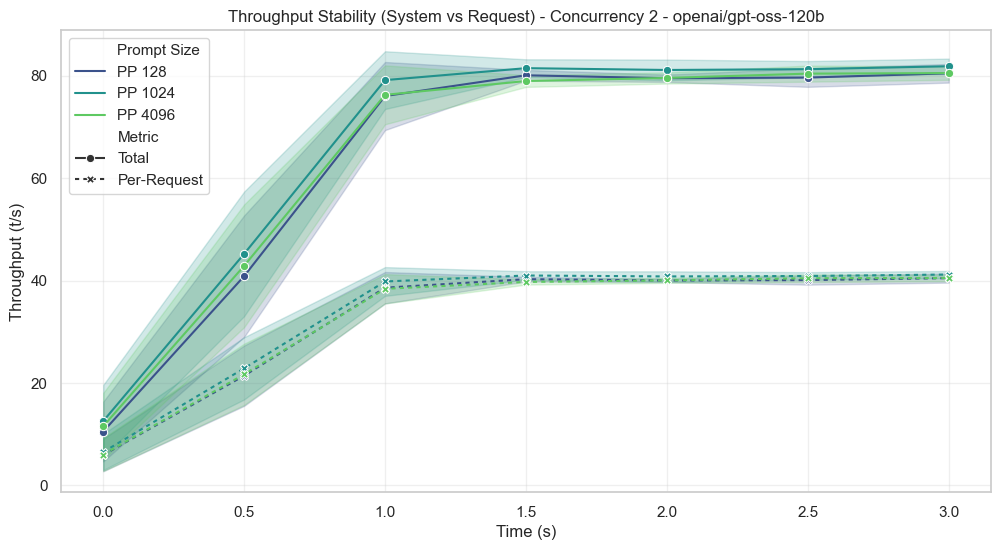

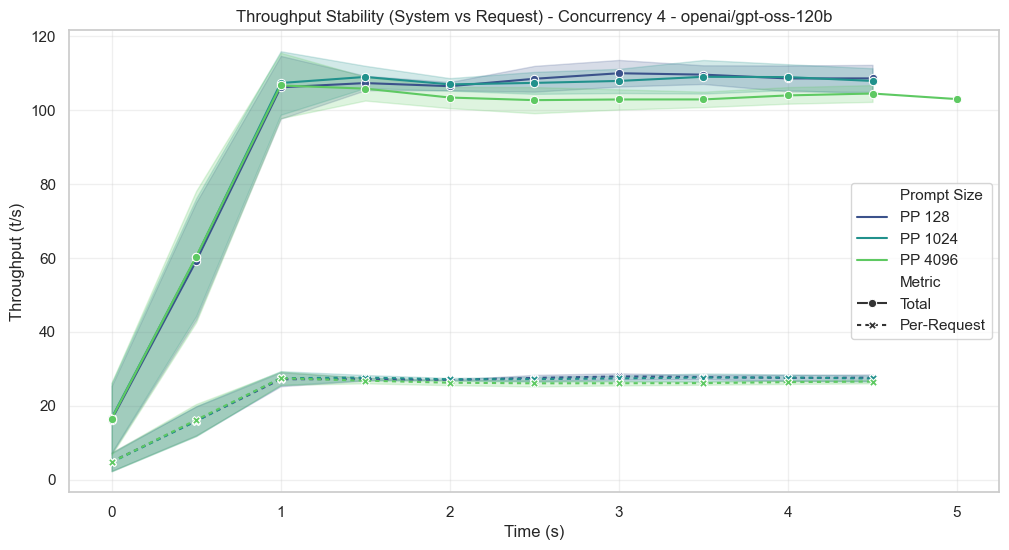

In [17]:
# Plot Throughput Over Time (System Total vs Per-Request) with Spread
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

has_data = False
all_time_series_data = []

# Binning resolution (seconds)
TIME_BIN_SIZE = 0.5 

for run in runner.results.runs:
    if not run.throughput_over_time and not run.requests_throughput_over_time:
        continue
    
    has_data = True
    
    # 1. Process System Total Throughput (across all runs)
    if run.throughput_over_time:
        for iteration_idx, trace in enumerate(run.throughput_over_time):
            if not trace: continue
            for t, val in trace:
                binned = round(t / TIME_BIN_SIZE) * TIME_BIN_SIZE
                all_time_series_data.append({
                    "Concurrency": run.concurrency,
                    "Prompt Size": f"PP {run.prompt_size}", 
                    "Time (s)": binned,
                    "Throughput (t/s)": val,
                    "Metric": "Total" # Label for distinguishing lines
                })

    # 2. Process Per-Request Throughput (across all runs & requests)
    if run.requests_throughput_over_time:
        for iteration_idx, batch in enumerate(run.requests_throughput_over_time):
            for req_idx, trace in enumerate(batch):
                if not trace: continue
                # Optional: Filter out failed requests if needed
                for t, val in trace:
                    binned = round(t / TIME_BIN_SIZE) * TIME_BIN_SIZE
                    all_time_series_data.append({
                        "Concurrency": run.concurrency,
                        "Prompt Size": f"PP {run.prompt_size}",
                        "Time (s)": binned,
                        "Throughput (t/s)": val,
                        "Metric": "Per-Request" # Label for distinguishing lines
                    })

if has_data:
    df_ts = pd.DataFrame(all_time_series_data)
    unique_concurrencies = sorted(df_ts["Concurrency"].unique())
    
    for concurrency in unique_concurrencies:
        plt.figure(figsize=(12, 6))
        df_subset = df_ts[df_ts["Concurrency"] == concurrency]
        
        # Plot with hue=Prompt Size and style=Metric (Total vs Per-Request)
        sns.lineplot(
            data=df_subset, 
            x="Time (s)", 
            y="Throughput (t/s)", 
            hue="Prompt Size", 
            style="Metric",       # Different dash patterns for System vs Per-Request
            palette="viridis",
            markers=True,         # Add markers to distinct points
            dashes={"Total": (1, 0), "Per-Request": (2, 2)}, # Solid vs Dashed
            estimator="mean",
            errorbar="sd"         # Shaded band for standard deviation
        )
        
        plt.title(f"Throughput Stability (System vs Request) - Concurrency {concurrency} - {MODEL_NAME}")
        plt.grid(True, alpha=0.3)
        plt.show()

else:
    print("No time-series data available. Ensure save_all_throughput_data=True in config.")

## Throughput Over Time
This plot shows the throughput stability over the duration of the test runs. We pick the first run for each configuration.

## Export Results

Save the raw results to a JSON file.

In [10]:
output_file = "benchmark_results.json"
runner.results.save_report(output_file, "json")
print(f"Results saved to {output_file}")

Saving results to benchmark_results.json in JSON format...


Results saved to benchmark_results.json
